In [ ]:
%load_ext autoreload
%autoreload 2
from alignment_images import alignment_images, plot_images
import torch
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)
LOG = logging.getLogger("Train")

In [3]:
contig="chr10"
start= 92631751  
stop=92631761

genomic_img = alignment_images(
    bam_fn='test.sorted.bam',
    contig=contig,
    start=start,
    stop=stop,
)

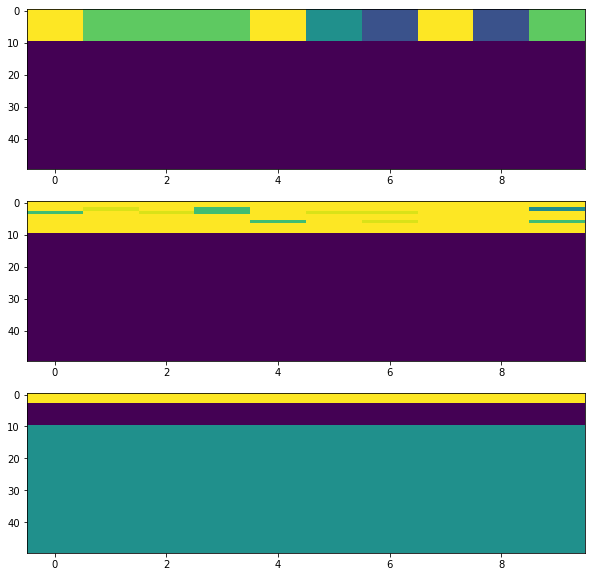

In [4]:
plot_images(genomic_img)

In [144]:
genomic_img[0, :, 4] 

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int8)

In [301]:
data_set = []
ys = []

for i in range(10000):
    if i % 2 == 0:
        mut_img = np.random.normal(size= np.product(genomic_img.shape))
        mut_img = mut_img.reshape(genomic_img.shape)
        data_set.append(mut_img)
    else:
        data_img = genomic_img.copy()
        data_img[1,:,:] = data_img[1,:,:] + np.random.normal(loc=0, size=np.product(genomic_img[0].shape)).reshape(genomic_img[1].shape)
        data_set.append(genomic_img)
    ys.append(i % 2)
data_set=np.array(data_set)
ys=np.array(ys)

In [302]:
class PseudoSlayClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
          
        minibatch = 30 
        read_depth = 50
        base_window_size = 10
        base_move_step = 2
        
        self.conv_layer = torch.nn.Conv2d(
            in_channels=3,
            out_channels=1,
            kernel_size=(read_depth, base_window_size), # scanning 200bp and all 50 reads at a time
            stride=base_move_step, # moving 20bp at a time
            padding=2
        )
        self.max_pool = torch.nn.MaxPool2d(kernel_size = (2,1)) # taking 10 best features
        self.drop_out = torch.nn.Dropout(p=0.2)
        self.linear = torch.nn.Linear(3, 1)
        
        # set up model
        self.model = torch.nn.Sequential(
            self.conv_layer,
            torch.nn.ReLU(),
            self.max_pool,
            self.drop_out,
            self.linear,
            torch.nn.Sigmoid()
        )
  
    def forward(self, x):
        return self.model(x)

In [303]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def calculate_metrics(y, pred_y, epoch, loss):
    '''
    Output some metrics
    '''
    pred_label = pred_y.detach().numpy().round()
    accuracy = accuracy_score(y, pred_label)
    precision = precision_score(y, pred_label)
    recall = recall_score(y, pred_label)
    f1 = f1_score(y, pred_label)
    LOG.info(
        'Mini-batch: %.3f Loss: %.3f Accuracy: %.3f'
        ' F1: %.3f Precision %.3f Recall %.3f', 
        epoch, 
        loss, 
        accuracy, 
        f1, 
        precision, 
        recall
    )
    


model = PseudoSlayClassifier()
optimizer = torch.optim.Adam(model.parameters(), 
                          lr = 0.001)

In [304]:
losses = []
steps=10000
for step in range(steps):
    optimizer.zero_grad()

    # get data
    idx = np.random.randint(0,500, size=10)
    X = torch.Tensor(data_set[idx])
    y = torch.Tensor(ys[idx])

    #get prediction (forward)
    pred_y = model(X)
    pred_y = pred_y.view(-1)
    #assert sum(pred_y != pred_y).item() == 0, pred_y
    loss = torch.nn.functional.binary_cross_entropy(pred_y, y)
    losses.append(loss.detach().numpy())

    # update gradient
    loss.backward()
    optimizer.step()
    if step % 1000 == 0:
        calculate_metrics(y.detach().numpy(), pred_y, epoch=step, loss=float(loss.detach().numpy()) )

/Users/wckdouglas/code/mambaforge/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:Train:Mini-batch: 0.000 Loss: 0.732 Accuracy: 0.500 F1: 0.000 Precision 0.000 Recall 0.000
INFO:Train:Mini-batch: 1000.000 Loss: 0.215 Accuracy: 1.000 F1: 1.000 Precision 1.000 Recall 1.000
INFO:Train:Mini-batch: 2000.000 Loss: 0.151 Accuracy: 1.000 F1: 1.000 Precision 1.000 Recall 1.000
INFO:Train:Mini-batch: 3000.000 Loss: 0.103 Accuracy: 1.000 F1: 1.000 Precision 1.000 Recall 1.000
INFO:Train:Mini-batch: 4000.000 Loss: 0.066 Accuracy: 1.000 F1: 1.000 Precision 1.000 Recall 1.000
INFO:Train:Mini-batch: 5000.000 Loss: 0.008 Accuracy: 1.000 F1: 1.000 Precision 1.000 Recall 1.000
INFO:Train:Mini-batch: 6000.000 Loss: 0.017 Accuracy: 1.000 F1: 1.000 Precision 1.

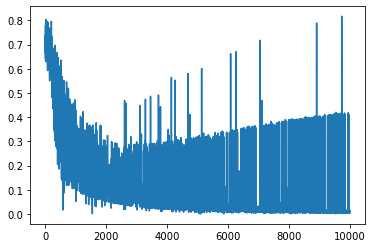

In [305]:
plt.plot(losses)

In [306]:
pred_y = model(X)

In [307]:
pred = (pred_y.detach().numpy().reshape(-1))
pred[pred>0.5]=1
pred[pred<0.5]=0

In [308]:
y

tensor([1., 1., 1., 0., 1., 1., 1., 0., 0., 0.])

In [309]:
pred

array([1., 1., 1., 0., 1., 1., 1., 0., 0., 0.], dtype=float32)